#### Students Name and ID:
- Lukas Stark, 20220626
- David Halder, 20220632
- Felix Gaber, 20221385
- Felix Gayer, 20220320

In [ ]:
%pip install mlflow

Python interpreter will be restarted.
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143878 sha256=71fbd3f8b346bd124a5243c6a47efa3a44ba3d7199ed8192aff845146edc73d9
  Stored in directory: /root/.cache/pip/wheels/b6/90/68/94d223a35a3910c1512a8d42d9f8333ce567ef26e250a56227
Successfully built databricks-cli
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-8574640c-eeec-41e9-b34f-d19717ee8e6c
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-8574640c-eeec-41e9-b34f-d19717ee8e6c
    Can't uninstall

In [ ]:
from pyspark.sql                import functions as f
from pyspark.sql.dataframe      import DataFrame

from pyspark.ml.evaluation      import MulticlassClassificationEvaluator
from pyspark.ml                 import Pipeline
from pyspark.ml.feature         import VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification  import LogisticRegression
from pyspark.ml.classification  import RandomForestClassifier
from pyspark.ml.tuning          import TrainValidationSplit

!python3 -m pip freeze --disable-pip-version-check --exclude-editable --no-cache-dir > requirements.txt

!pip install hyperopt
from hyperopt                   import hp, fmin, tpe, Trials
import mlflow

import pandas                   as pd
import seaborn                  as sns
import matplotlib.pyplot        as plt
from itertools                  import combinations

     |████████████████████████████████| 1.6 MB 5.3 MB/s 
     |████████████████████████████████| 2.1 MB 51.0 MB/s 
     |████████████████████████████████| 840 kB 22.7 MB/s 
     |████████████████████████████████| 200 kB 48.0 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492037 sha256=52c36190e06f075d42ca1cf67ccdb9ff230bae775580330b065ddb06ac9981f4
  Stored in directory: /root/.cache/pip/wheels/bf/5d/6a/2e53874f7ec4e2bede522385439531fafec8fafe005b5c3d1b
Successfully built future
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-8574640c-eeec-41e9-b34f-d19717ee8e6c/bin/python -m pip install --upgrade pip' command.


# Loading and exploring Data

In [ ]:
orders_sample = spark.read.parquet(f"/FileStore/bdm_data_train/train/ord_sample")
ab_test_sample = spark.read.parquet(f"/FileStore/bdm_data_train/train/mkt_test_assignment_sample")
sess_sample = spark.read.parquet(f"/FileStore/bdm_data_train/train/sess_sample")
items_sample = spark.read.parquet(f"/FileStore/bdm_data_train/train/items_sample")

In [ ]:
display(ab_test_sample)

In [ ]:
display(orders_sample)

In [ ]:
display(items_sample)

In [ ]:
display(sess_sample)

#### Step 1: Generating features and labels

In [ ]:
def generate_features(orders_df: DataFrame, items_df: DataFrame, ab_test: DataFrame, sess_df: DataFrame, start_date: str, end_date: str, test_control: str) -> DataFrame:
    """
    Generate features from the input DataFrame.
    
    :param orders_df: DataFrame containing order information.
    :param items_df: DataFrame containing item information.
    :param ab_test: DataFrame containing AB test information.
    :param sess_df: DataFrame containing session information.
    :param start_date: Start date for filtering the input DataFrames.
    :param end_date: End date for filtering the input DataFrames.
    :param test_control: Control group identifier for AB test.

    :return: DataFrame with generated features.
    """

    # Filter AB test DataFrame
    ab_ids_final = ab_test.filter(f.col("test_assignment") == test_control).select("account_id", "reference_date")
    print("ab_count", ab_ids_final.count())

    # Filter the DataFrames based on the specified timeframe
    orders_df = filter_dataframe_by_date(orders_df, start_date, end_date)
    print('orders_df len: ', orders_df.count())
    items_df = filter_dataframe_by_date(items_df, start_date, end_date)
    print('items_df len: ', items_df.count())
    sess_df = filter_dataframe_by_date(sess_df, start_date, end_date)
    print('sess_df len: ', sess_df.count())
    print("Filtering Done")

    # Perform account-level aggregations on orders DataFrame
    account_aggs = (
        orders_df.groupBy('account_id')
        .agg(
            f.countDistinct('order_id').alias('orders'),
            f.sum('order_total').alias('total_value'),
            f.max('reference_date').alias('most_recent_order_date'),
            f.min('reference_date').alias('first_order_date'),
            (f.sum('subsidy') / f.sum('order_total')).alias('subsidy_perc'),
            (f.sum("subsidy") / f.countDistinct("order_id")).alias("subsidy_per_order"),
            (f.countDistinct("discount_vouchers_used") / f.countDistinct("order_id")).alias("subsidized_orders_perc"),
            (f.countDistinct("order_origin")).alias("nr_of_origins")
        )
        .withColumn('days_since_last_order', f.datediff(f.lit(end_date), f.col('most_recent_order_date')))
        .withColumn('days_since_first_order', f.datediff(f.lit(end_date), f.col('first_order_date')))
        .drop("most_recent_order_date", "first_order_date")
    )

    # Perform monthly aggregations on orders DataFrame
    month_agg = (
        orders_df.groupBy('account_id', f.month('reference_date').alias('month'))
        .agg(
            f.countDistinct('order_id').alias('orders_per_month'),
            f.sum("order_total").alias("value_per_month")
        )
        .groupBy('account_id')
        .agg(
            f.avg('orders_per_month').alias('avg_orders_per_month'),
            f.avg('value_per_month').alias('avg_value_per_month')
        )
    )
    print("Account Aggregation Done", account_aggs.count())

    # Prepare the items DataFrame for aggregation
    items_agg = (
        items_df.withColumn('items_array', f.transform(f.col('order_content'), lambda x: x['taxonomy_level_2']))
        .withColumn('array_size', f.size(f.col('items_array')))
        .withColumn('unique_items', f.array_distinct(f.col('items_array')))
        .select('reference_date', 'order_id', f.explode(f.col('unique_items')).alias('items'))
    )

    # Prepare the categories DataFrame for aggregation
    cat_agg = (
        items_df.withColumn('items_array', f.transform(f.col('order_content'), lambda x: x['taxonomy_level_1']))
        .withColumn('array_size', f.size(f.col('items_array')))
        .withColumn('unique_categories', f.array_distinct(f.col('items_array')))
        .select('reference_date', 'order_id', f.explode(f.col('unique_categories')).alias('categories')) 
    )
    
    quant_agg = (
        items_df
        .withColumn('quantity_array', f.transform(f.col('order_content'), lambda x: x['quantity']))
        .withColumn('array_size', f.size(f.col('quantity_array')))
        .select('reference_date', 'order_id', f.expr('AGGREGATE(quantity_array, DOUBLE(0), (acc, x) -> acc + x)').alias('quantity'))
  )
    
    full_meal_agg = (
        items_df
        .withColumn('items_array', f.transform(f.col('order_content'), lambda x: x['taxonomy_level_1']))
        .withColumn('array_size', f.size(f.col('items_array')))
        .withColumn("full_meal", f.expr("int(array_contains(items_array, 'FULL_MEAL'))"))
        .select('reference_date', 'order_id', "full_meal")
)

    # Perform aggregations on items DataFrame
    items_agg = (
        items_agg
        .join(cat_agg, ['order_id'], 'inner')
        .join(quant_agg, "order_id", "inner")
        .join(full_meal_agg, "order_id", "inner")
        .groupBy("order_id")
        .agg(
            f.countDistinct("categories").alias("cat_per_order"),
            f.countDistinct("items").alias("items_per_order"), 
            f.sum("quantity").alias("quantity_per_order"),
            f.sum("full_meal").alias("orders_containing_full_meals")
        )
    )

    # Join items DataFrame with account_prep DataFrame
    account_prep = orders_df.select("account_id", "order_id")
    items_agg = items_agg.join(account_prep, "order_id")

    # Perform final aggregations on items DataFrame
    items_agg = (
        items_agg.groupBy("account_id")
        .agg(
            f.avg("cat_per_order").alias("avg_cat_po"),
            f.avg("items_per_order").alias("avg_items_po"), 
            f.avg("quantity_per_order").alias("avg_quant_po"),
            f.sum("orders_containing_full_meals").alias("full_meal_orders")
        )
    )
    print("Items Aggregation Done", items_agg.count())

    # Perform aggregations on session DataFrame
    sess_agg = (
        sess_df.groupBy('account_id', f.month('reference_date').alias('month'))
        .agg(
            f.countDistinct('session_id').alias('sessions_per_month'),
            f.sum(f.when(f.col('view_checkout'), 1).otherwise(0)).alias("view_checkout_per_month"),
            f.sum(f.when(f.col('view_dish'), 1).otherwise(0)).alias("view_dish_per_month"),
            f.sum(f.when(f.col('view_restaurant'), 1).otherwise(0)).alias("view_restaurant_per_month"),
            f.sum(f.when(f.col('order_id') != 'Null', 1).otherwise(0)).alias("orders_per_month")
        )
        .groupBy('account_id')
        .agg(
            f.avg('view_checkout_per_month').alias('avg_view_checkout_per_month'),
            f.avg('view_dish_per_month').alias('avg_view_dish_per_month'),
            f.avg('sessions_per_month').alias('avg_sessions_per_month'),
            f.avg('view_restaurant_per_month').alias('avg_view_restaurant_per_month')
        )
    )

    # Perform aggregations on session time DataFrame
    sess_time_agg = (
        sess_df.withColumn('started_at', f.to_timestamp(f.col('started_at'), 'yyyy-MM-dd\'T\'HH:mm:ss.SSSZ'))
        .withColumn('closed_at', f.to_timestamp(f.col('closed_at'), 'yyyy-MM-dd\'T\'HH:mm:ss.SSSZ'))
        .withColumn('session_time', (f.col('closed_at').cast('long') - f.col('started_at').cast('long')) / 60)
        .groupBy('account_id')
        .agg(
            f.avg('session_time').alias('average_session_time')
        )
    )

    # Join session and session time DataFrames
    sess_agg = sess_agg.join(sess_time_agg, 'account_id', 'left')

    # Join all DataFrames together
    joined_df = (
        ab_ids_final.join(account_aggs, "account_id", "left")
        .join(month_agg, 'account_id', 'left')
        .join(items_agg, 'account_id', 'left')
        .join(sess_agg, 'account_id', 'left')
    )

    joined_df = joined_df.fillna(0)
    print("Final Row Number", joined_df.count())

    return joined_df


def filter_dataframe_by_date(dataframe: DataFrame, start_date: str, end_date: str) -> DataFrame:
    """
    Filter the DataFrame based on the specified start and end dates.

    :param dataframe: Input DataFrame to be filtered.
    :param start_date: Start date for filtering.
    :param end_date: End date for filtering.

    :return: Filtered DataFrame.
    """
    return dataframe.filter((f.col('reference_date') >= start_date) & (f.col('reference_date') <= end_date))

In [ ]:
features=generate_features(
  orders_sample, #Order Data
  items_sample, #Item Data
  ab_test_sample, #Ab-test data -> only june or july
  sess_sample, #session data
  "2021-03-01", #start of the analysis timeframe
  "2021-05-30", #end of the analysis timeframe
  "test") #test or control group

features.display()

In [ ]:
def generate_labels(orders_data: DataFrame, ab_data: DataFrame) -> DataFrame:
    """
    Generate labels for the input DataFrame.
    
    :param orders_data: Input DataFrame containing order information.
    :param ab_data: DataFrame containing AB test assignment data.
    
    :return: DataFrame with generated labels.
    """
    
    # Filter AB test assignment data for 'test' assignment and select required columns
    ab_data_filtered = ab_data.filter(f.col("test_assignment") == "test").select("account_id", "reference_date")

    # Group orders by account_id and reference_date, select maximum discount_vouchers_used value for each group
    orders_by_account = orders_data.select("account_id", "reference_date", "discount_vouchers_used") \
        .groupBy("account_id", "reference_date") \
        .agg(f.max("discount_vouchers_used").alias("discount_vouchers_used"))

    # Join AB test assignment data with orders data, calculate label based on discount_vouchers_used column
    labels_df = ab_data_filtered.join(orders_by_account, on=['account_id', 'reference_date'], how='left') \
        .withColumn("label", f.when(f.col("discount_vouchers_used") == 1, 1).otherwise(0)) \
        .drop(f.col('discount_vouchers_used'))

    return labels_df


In [ ]:
def generate_features_and_labels(
  orders_data=orders_sample,
  items_data=items_sample,
  ab_data=ab_test_sample,
  session_data=sess_sample,
  start_date="2021-01-01",
  end_date="2021-05-31", 
  test = "test"
  ) -> DataFrame:

  features_df = generate_features(
    orders_data, #Order Data
    items_data, #Item Data
    ab_data, #Ab-test data -> only june or july
    session_data, #session data
    start_date, #start of the analysis timeframe
    end_date, #end of the analysis timeframe
    "test") #test or control group
  
  labels_df = generate_labels(orders_data, ab_data)
  
  output_df = labels_df.join(features_df, ['account_id', 'reference_date'], 'inner')
  return output_df

In [ ]:
feature_df = generate_features_and_labels(orders_data=orders_sample,
                                    items_data=items_sample,
                                    ab_data=ab_test_sample,
                                    session_data=sess_sample,
                                    start_date="2021-01-01",
                                    end_date="2021-05-31", 
                                    test = "test"
                                    )
  

ab_count 164586
Filtering Done
Account Aggregation Done 87201
Items Aggregation Done 87201
Final Row Number 164586


materialize the procecced dataset before starting the tuning to reduce the tuning time

In [ ]:
feature_df.write.mode("overwrite").parquet("/FileStore/bdm_data_train/feature_data.parquet")

> *Features & Label documentation*

**Labels:**
We decided to go for the one model approach. That means foe the training of the model only the customer assigned to the treatment-group will be considered. The labels are calculated as follows:
> Customers who got an incentive (assigned to the test group) and converted (order usinf a voucher) get the label *"1"*
 > Customers who got an incentive (assigned to the test group) and did not respond get the label *"0"*

The objective is to build a ML-Pipeline to correctly identify the persuadable customers ("1"), in order to maximize the campaign incremental profit.

**Features:**

*account_id*: This variable represents the individual customer or account, which is essential for tracking the treatment and control groups and understanding the differential effects.

*orders*: The number of orders made by each account can indicate the level of engagement or activity. It helps assess the overall behavior and responsiveness of customers.

*total_value*: The total value of orders placed by each account reflects the monetary impact and customer spending patterns. Higher values may indicate more valuable or lucrative customers.

*subsidy_perc*: The subsidy percentage represents the proportion of subsidy relative to the order total. It can provide insights into the extent of discount or promotional incentives offered to customers.

*subsidy_per_order*: This variable indicates the average subsidy amount per order. It helps evaluate the level of financial support provided to customers and its potential impact on their behavior.

*subsidized_orders_perc*: The percentage of subsidized orders relative to the total number of orders highlights the prevalence of subsidized purchases and can be indicative of customers who are more likely to respond to discounts.

*nr_of_origins*: The number of order origins provides information about the diversity of platforms or channels used by customers. It can help identify whether certain channels are more effective in driving uplift.

*days_since_last_order*: The number of days since the last order can capture recency effects, as customers who have recently placed an order may exhibit different behavior than those who have not.

*days_since_first_order*: The number of days since the first order indicates the customer's tenure or longevity. Long-standing customers may respond differently to treatment compared to newer customers.

*avg_orders_per_month*: The average number of orders placed per month provides insights into the regularity and frequency of customer transactions. It helps identify customers with different purchasing patterns.

*avg_value_per_month*: The average value of orders per month reflects the average spending behavior of customers over time. It can capture trends and changes in customer spending.

*avg_cat_po*: The average number of categories per order signifies the diversity of product categories purchased by customers. It can help identify customers with varied interests and potentially different response patterns.

*avg_items_po*: The average number of items per order indicates the size of purchases made by customers. It can provide insights into the level of engagement and potential cross-selling opportunities in terms of voucher categories.

*avg_quant_po*:The average quantity per order is a useful variable for uplift modeling since it helps differentiate customers based on their purchasing behavior and identifies those with a higher potential for increased spending. It shows which customers buy items in large amounts and thus could help identify customers who could react to an incentive.

*full_meal_orders*: The number of full meal orders can be a good variable for uplift modeling since it represents a specific behavior of customers, indicating their preference for complete meals. By including this variable, you can identify customers who are more likely to respond positively to a treatment related to full meal offers.

*avg_view_checkout_per_month*: The average number of times customers view the checkout page per month can indicate their intent to make a purchase. It helps capture the engagement level and readiness to convert.

*avg_view_dish_per_month*: The average number of times customers view dish-related content per month reflects their interest in specific products. It can be relevant for personalization and targeting.

*avg_sessions_per_month*: The average number of sessions per month represents the level of engagement or activity on the platform. It helps identify customers who are more active or invested.

*avg_view_restaurant_per_month*: The average number of times customers view restaurant-related content per month indicates their exploration of different options. It can be relevant for understanding preferences and preferences.

*average_session_time:* The average duration of customer sessions provides insights into their level of engagement and attention. Longer sessions may indicate higher interest or involvement.

#### Step 2: The ML Pipeline

In [ ]:
data = spark.read.parquet("/FileStore/bdm_data_train/feature_data.parquet")
train_data, test_data = data.randomSplit([0.7, 0.3], seed=420)

In [ ]:
from pyspark.sql.window import Window

# Calculate class frequencies
class_freq = train_data.groupBy("label").count()

# Calculate class weights based on class frequencies
window_spec = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
class_weights = class_freq.withColumn("weight", f.lit(1) / (f.col("count") / f.sum("count").over(window_spec)))

train_data = train_data.join(class_weights, "label")


##### Define assembler, scaler & classifier

In [ ]:
feature_columns = [col for col in train_data.columns if col != 'label' and col != 'account_id'and col != 'reference_date'and col != 'weight' and col != 'count']

imputer = Imputer(inputCols=feature_columns, outputCols=[col + '_imputed' for col in feature_columns])
assembler = VectorAssembler(inputCols=[col + '_imputed' for col in feature_columns], outputCol='raw_features')
scaler = StandardScaler(inputCol='raw_features', outputCol='scaled_features')

lr_classifier = LogisticRegression(featuresCol='scaled_features', labelCol='label', weightCol="weight")
rf_classifier = RandomForestClassifier(featuresCol='scaled_features', labelCol='label',weightCol="weight")

print(feature_columns)

['orders', 'total_value', 'subsidy_perc', 'subsidy_per_order', 'subsidized_orders_perc', 'nr_of_origins', 'days_since_last_order', 'days_since_first_order', 'avg_orders_per_month', 'avg_value_per_month', 'avg_cat_po', 'avg_items_po', 'avg_quant_po', 'full_meal_orders', 'avg_view_checkout_per_month', 'avg_view_dish_per_month', 'avg_sessions_per_month', 'avg_view_restaurant_per_month', 'average_session_time']


##### Define the pipelines

In [ ]:
pipe_lr = Pipeline(stages=[imputer,
                           assembler, 
                           scaler, 
                           lr_classifier])

pipe_rf = Pipeline(stages=[imputer,
                           assembler, 
                           scaler, 
                           rf_classifier])

##### Evaluate baseline model performance with LinearRegression

In [ ]:
model_baseline_lr = pipe_lr.fit(train_data)
predictions_baseline_lr = model_baseline_lr.transform(test_data)

In [ ]:
#model_baseline_lr.save('/FileStore/bdm_data_train/model_baseline_lr')

confusion_matrix = (
    predictions_baseline_lr
    .groupBy('label')
    .pivot('prediction', [0, 1])
    .count()
    .fillna(0)
)

# Print the confusion matrix
confusion_matrix.show()

+-----+-----+-----+
|label|    0|    1|
+-----+-----+-----+
|    1|   27|  238|
|    0|38862|10621|
+-----+-----+-----+



##### Evaluate baseline model performance with RandomForest

In [ ]:
model_baseline_rf = pipe_rf.fit(train_data)
predictions_baseline_rf = model_baseline_rf.transform(test_data)

In [ ]:
#model_baseline_rf.save('/FileStore/bdm_data_train/model_baseline_rf')

confusion_matrix = (
    predictions_baseline_rf
    .groupBy('label')
    .pivot('prediction', [0, 1])
    .count()
    .fillna(0)
)

# Print the confusion matrix
confusion_matrix.show()

+-----+-----+----+
|label|    0|   1|
+-----+-----+----+
|    1|   33| 232|
|    0|40139|9344|
+-----+-----+----+



> **Why did you choose each step of your ML Pipeline?**

**Imputer**: The Imputer step is used to handle missing values in the dataset. It replaces the missing values with some estimated values based on the available data. In this case, the Imputer is configured to impute missing values in the specified feature columns.

**VectorAssembler**: The VectorAssembler step is responsible for combining multiple feature columns into a single vector column. It takes the imputed feature columns as input and outputs a new column that contains a vector representation of the features. This is often required as most ML algorithms expect the input features to be in vector format.

**StandardScaler**: The StandardScaler step is used for feature scaling. It transforms the vector of features by subtracting the mean and dividing by the standard deviation, which helps to normalize the feature values. Scaling is important because it ensures that features with larger magnitudes do not dominate the learning process compared to features with smaller magnitudes.

**LogisticRegression**: The LogisticRegression step represents a machine learning algorithm, specifically a logistic regression classifier. It takes the scaled features as input and the specified label column, and it learns to predict the label based on the input features. Logistic regression is a popular algorithm for binary classification tasks.

**RandomForestClassifier**: The RandomForestClassifier step represents another machine learning algorithm, namely a random forest classifier. Similar to logistic regression, it takes the scaled features and the label column as input and learns to predict the label based on the features. Random forest classifiers are known for their ability to handle complex relationships in data and are often used for classification tasks.

#### Step 3: Tuning the hyperparameters of your model

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", 
                                              predictionCol='prediction', 
                                              metricName="f1")


##### tuning the hyperparameter for the LinearRegression pipeline

In [ ]:
mlflow.set_experiment('/Users/flixflex@gmx.net/lr_classifier')

# Define the search space
search_space = {
    'maxIter': hp.choice('maxIter', [10, 50, 100]),
    'regParam': hp.choice('regParam', [0.0, 0.05, 0.1]),
    'elasticNetParam': hp.choice('elasticNetParam', [0.0, 0.3, 0.5]),
    'fitIntercept': hp.choice('fitIntercept', [True, False]),
    'standardization': hp.choice('standardization', [True, False]),
    'tol': hp.choice('tol', [1e-4, 5e-5, 1e-6])
}

# Define the objective function
def objective(params):
    # Start an MLflow run to track the experiment
    with mlflow.start_run():
        # Set the parameters in the classifier
        lr_classifier.setParams(**params)
        
        # Fit the Pipeline to the training data
        model = pipe_lr.fit(train_data)

        # Make predictions on the test data
        predictions = model.transform(test_data)
        
        f1 = evaluator.evaluate(predictions)
            
        # Log the hyperparameters and evaluation metrics to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("f1", f1)
        mlflow.spark.log_model(model, "model", pip_requirements="requirements.txt")

        return -f1  

# Perform the grid search
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,  
    trials=trials
)


100%|██████████| 10/10 [10:59<00:00, 65.90s/trial, best loss: -0.8893441088260539]


##### tuning the hyperparameter for the RandomForest pipeline

In [ ]:
mlflow.set_experiment('/Users/flixflex@gmx.net/rf_classifier')

# Define the search space
search_space = {
    'maxDepth': hp.choice('maxDepth', [5, 10, 15]),
    'numTrees': hp.choice('numTrees', [50, 100, 150]),
    'subsamplingRate': hp.choice('subsamplingRate', [0.5, 0.75, 1.0]),
    'featureSubsetStrategy': hp.choice('featureSubsetStrategy', ['auto', 'sqrt', 'log2']),
    'minInstancesPerNode': hp.choice('minInstancesPerNode', [1, 5, 10]),
    'maxBins': hp.choice('maxBins', [16, 32, 64])
}

# Define the objective function
def objective(params):
    # Start an MLflow run to track the experiment
    with mlflow.start_run():
        # Set the parameters in the classifier
        rf_classifier.setParams(**params)
        
        # Fit the Pipeline to the training data
        model_rf = pipe_rf.fit(train_data)

        # Make predictions on the test data
        predictions = model_rf.transform(test_data)

        
        f1 = evaluator.evaluate(predictions)
            
        # Log the hyperparameters and evaluation metrics to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("f1", f1)
        mlflow.spark.log_model(model_rf, "model", pip_requirements="requirements.txt")

        return -f1  

# Perform the grid search
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,  
    trials=trials
)

100%|██████████| 10/10 [28:46<00:00, 172.67s/trial, best loss: -0.9897061381072175]


>**Which metrics did you choose for evaluation? Justify.**

F1 score was not only used in the practical classes, is a commonly used metric for evaluating the performance of classification models, especially in scenarios where the classes are imbalanced or when both precision and recall are equally important. In our case both factors count. F1 score provides a single value that summarizes the overall performance of a classification model. This makes it convenient for model comparison and selection, as it allows for a straightforward comparison of different models (in our case LinearRegression and RandomForest) based on their ability to balance precision and recall.

...

**Results of our hyperparameter tuning - analysed by heatmaps**

In [ ]:
def generate_pair_heatmap_spark(dataframe, selected_columns, metric_column):
    # Rename columns by replacing dots with underscores
    renamed_columns = [col.replace('.', '_') for col in dataframe.columns]
    dataframe = dataframe.toDF(*renamed_columns)

    # Select the relevant columns for analysis
    data = dataframe.select(*selected_columns, metric_column)

    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = data.toPandas()

    # Filter columns containing 'metrics' for the x-axis
    x_column = selected_columns[0]

    # Filter columns containing 'params' for the y-axis
    y_column = selected_columns[1]

    # Create a pivot table
    pivot_table = pd.pivot_table(pandas_df, values=metric_column, index=y_column, columns=x_column)

    # Create a heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')

    # Set the labels for x-axis and y-axis
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    

    # Display the heatmap
    plt.show()


def generate_all_pair_heatmaps(metrics_df, columns, metric_column):
    for col1, col2 in combinations(columns, 2):
        print(f"Generating heatmap for columns: {col1}, {col2}")
        generate_pair_heatmap_spark(metrics_df,[col1, col2], metric_column)
        print('\n\n')

**For LinearRegression**

Is there any parameter more correlated to the evaluation metrics? What is your hypothesis about this?

In [ ]:
metrics_df.display()

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1,params.featureSubsetStrategy,params.maxBins,params.numTrees,params.subsamplingRate,params.minInstancesPerNode,params.maxDepth,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.user,tags.mlflow.databricks.workspaceID,tags.mlflow.databricks.workspaceURL,tags.mlflow.databricks.notebookPath,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.databricks.notebookID,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.databricks.cluster.info,tags.mlflow.databricks.notebook.commandID,tags.mlflow.databricks.webappURL,tags.mlflow.databricks.cluster.libraries
67b6dc5667f94346a8616f889428fc01,3971974859204855,FINISHED,dbfs:/databricks/mlflow-tracking/3971974859204855/67b6dc5667f94346a8616f889428fc01/artifacts,2023-06-06T16:27:19.068+0000,2023-06-06T16:33:52.793+0000,0.9889359853039082,log2,64,150,0.5,1,15,0606-104534-wms2oie6,1686069232945,flixflex@gmx.net,6010521954952532,https://community.cloud.databricks.com,/Users/flixflex@gmx.net/Final Project - 20220626_20220632_20221385_20220320,/Users/flixflex@gmx.net/Final Project - 20220626_20220632_20221385_20220320,dazzling-jay-697,3846230048191079,NOTEBOOK,"[{""artifact_path"":""model"",""flavors"":{""spark"":{""pyspark_version"":""3.3.2.dev0"",""model_data"":""sparkml"",""code"":null},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.9.5"",""data"":""sparkml"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""}}},""run_id"":""67b6dc5667f94346a8616f889428fc01"",""model_uuid"":""293cf9c464374d4683d5975cd866813d"",""utc_time_created"":""2023-06-06 16:33:52.238082"",""mlflow_version"":""2.4.0"",""databricks_runtime"":""12.2.x-scala2.12""}]","{""cluster_name"":""butterfisch"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",2405399863064449464_5650335291784570058_a2f09ba1e3134b03beb5086562eef9a2,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}"
5b4312cf0c2e42fba93b3806050fe51b,3971974859204855,FINISHED,dbfs:/databricks/mlflow-tracking/3971974859204855/5b4312cf0c2e42fba93b3806050fe51b/artifacts,2023-06-06T16:24:32.697+0000,2023-06-06T16:27:18.893+0000,0.9621674389536007,sqrt,16,100,1.0,5,10,0606-104534-wms2oie6,1686068839030,flixflex@gmx.net,6010521954952532,https://community.cloud.databricks.com,/Users/flixflex@gmx.net/Final Project - 20220626_20220632_20221385_20220320,/Users/flixflex@gmx.net/Final Project - 20220626_20220632_20221385_20220320,worried-vole-653,3846230048191079,NOTEBOOK,"[{""artifact_path"":""model"",""flavors"":{""spark"":{""pyspark_version"":""3.3.2.dev0"",""model_data"":""sparkml"",""code"":null},""python_function"":{""loader_module"":""mlflow.spark"",""python_version"":""3.9.5"",""data"":""sparkml"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""}}},""run_id"":""5b4312cf0c2e42fba93b3806050fe51b"",""model_uuid"":""65775365e3514c0b9087e23abf2f6e0f"",""utc_time_created"":""2023-06-06 16:27:18.301694"",""mlflow_version"":""2.4.0"",""databricks_runtime"":""12.2.x-scala2.12""}]","{""cluster_name"":""butterfisch"",""spark_version"":""12.2.x-scala2.12"",""node_type_id"":""dev-tier-node"",""driver_node_type_id"":""dev-tier-node"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""num_workers"":0}",2405399863064449464_5650335291784570058_a2f09ba1e3134b03beb5086562eef9a2,https://community.cloud.databricks.com,"{""installable"":[],""redacted"":[]}"
bc5a620a17454688975e5968d6f9edfd,3971974859204855,FINISHED,dbfs:/databricks/mlflow-tracking/3971974859204855/bc5a620a17454688975e5968d6f9edfd/artifacts,2023-06-06T16:21:49.830+0000,2023-06-06T16:24:32.555+0000,0.9655879488485462,auto,32,100,1.0,5,10,0606-104534-wms2oie6,1686068672740,flixflex@gmx.net,6010521954952532,https://community.cloud.databricks.com,/Use

Generating heatmap for columns: params_maxIter, params_standardization


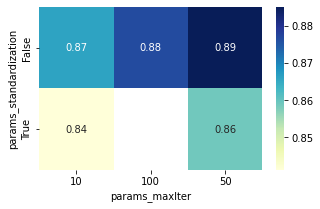




Generating heatmap for columns: params_maxIter, params_regParam


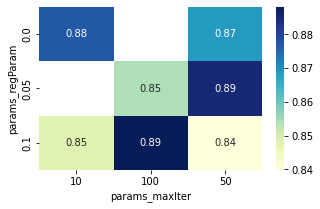




Generating heatmap for columns: params_maxIter, params_elasticNetParam


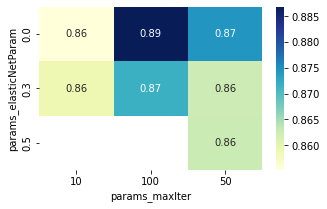




Generating heatmap for columns: params_maxIter, params_fitIntercept


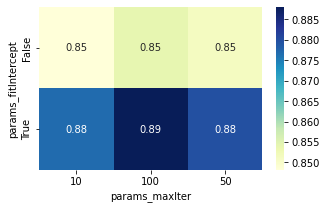




Generating heatmap for columns: params_maxIter, params_tol


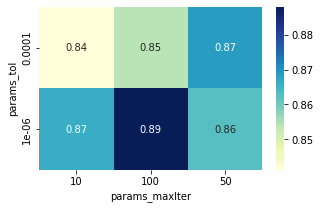




Generating heatmap for columns: params_standardization, params_regParam


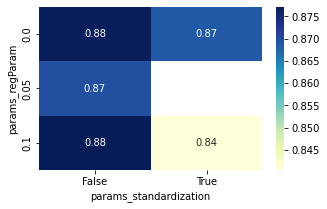




Generating heatmap for columns: params_standardization, params_elasticNetParam


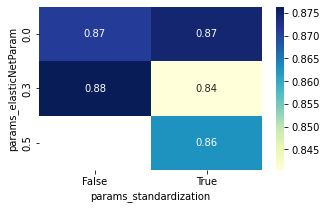




Generating heatmap for columns: params_standardization, params_fitIntercept


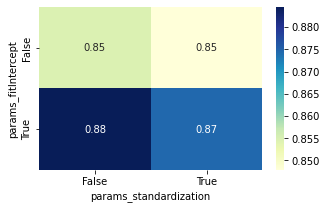




Generating heatmap for columns: params_standardization, params_tol


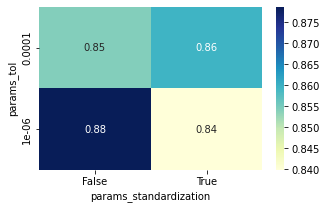




Generating heatmap for columns: params_regParam, params_elasticNetParam


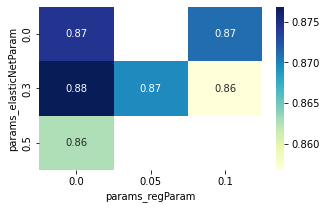




Generating heatmap for columns: params_regParam, params_fitIntercept


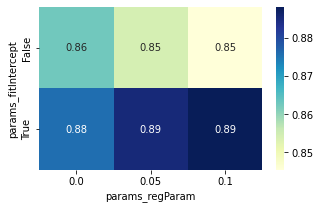




Generating heatmap for columns: params_regParam, params_tol


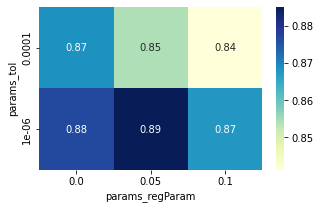




Generating heatmap for columns: params_elasticNetParam, params_fitIntercept


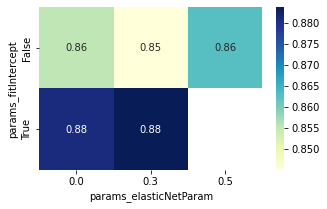




Generating heatmap for columns: params_elasticNetParam, params_tol


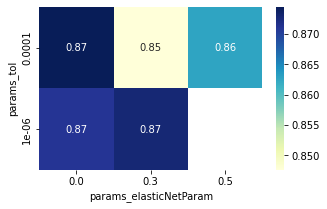




Generating heatmap for columns: params_fitIntercept, params_tol


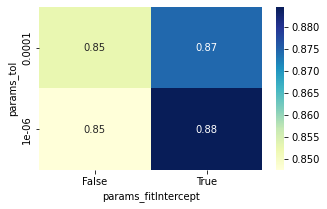

In [ ]:
expId = [3971974859204854]
runs = mlflow.search_runs(experiment_ids=expId)
metrics_df = spark.createDataFrame(runs)
        
columns = ['params_maxIter', 
           'params_standardization', 
           'params_regParam', 
           'params_elasticNetParam', 
           'params_fitIntercept', 
           'params_tol']

metric_column = 'metrics_f1'

generate_all_pair_heatmaps(metrics_df, columns, metric_column)

**Loading the best parameter value combination for LinearRegression**

In [ ]:
experiment_id = "3971974859204854"

# Load metadata of the best run from the experiment
best_run = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["metrics.f1 desc"], max_results=1)

metric_value = best_run.iloc[0]["metrics.f1"]

# Print the value of the metric
print("metric: {}".format(metric_value))

# Load the run ID of the best run
model_uri = "runs:/{}/model".format(best_run.iloc[0].run_id)

# Load parameters of the best run
model_final_lr = mlflow.spark.load_model(model_uri)
parameters = model_final_lr.stages[-1].extractParamMap()

# Print best parameters
for param_name, param_value in parameters.items():
    print("{}: {}".format(param_name.name, param_value))

2023/06/10 18:36:08 INFO mlflow.spark: 'runs:/146949d538cc40268355c2fe1bd44ec7/model' resolved as 'dbfs:/databricks/mlflow-tracking/3971974859204854/146949d538cc40268355c2fe1bd44ec7/artifacts/model'


metric: 0.8893441088260539


2023/06/10 18:36:15 INFO mlflow.spark: URI 'runs:/146949d538cc40268355c2fe1bd44ec7/model/sparkml' does not point to the current DFS.
2023/06/10 18:36:15 INFO mlflow.spark: File 'runs:/146949d538cc40268355c2fe1bd44ec7/model/sparkml' not found on DFS. Will attempt to upload the file.
2023/06/10 18:36:21 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/c612f5a9-59df-4fca-bfd6-3b1b20cab625


aggregationDepth: 2
elasticNetParam: 0.3
family: auto
featuresCol: scaled_features
fitIntercept: True
labelCol: label
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.1
standardization: False
threshold: 0.5
tol: 1e-06
weightCol: weight


## Evaluation of Parameter Score Combination for Logistic Regression Model

In our analysis, we aim to find the optimal parameter combinations for our Logistic Regression model that will provide us with the best F1 score.

### Parameter Combinations and Correlation Analysis

The parameters that we are considering for tuning include:

- `params_maxIter`
- `params_standardization`
- `params_regParam`
- `params_elasticNetParam`
- `params_fitIntercept`
- `params_tol`

### Parameter Combinations and Correlation Analysis

After analyzing the correlations between these parameters, we found interesting trends. The following are two examples of observations:

1. `params_maxIter` and `params_fitIntercept`: Interestingly, with this combination there is no difference in the score when changing number of `params_maxIter`, neither with `params_fitIntercept` being set to `True` or `False`. The only difference that can be observed is that when `params_fitIntercept` is set to `True`, we get better results. This is a good example that the evaluation should not be done on two parameters only, even if it provides a feeling for the parameters. 

2. `params_regParam` and `params_elasticNetParam`: 
Here we can also make interesting observations. It can be observed that it makes no difference what value we use for `params_elasticNetParam` as long as `params_regParam` is set to 0. However, if we have a value of 0.05 for `params_regParam`, for example, the score increases as `params_elasticNetParam` decreases (up to an f1 score of 0.89 in the case of `params_elasticNetParam`=0).


In light of these observations, we can see that the choice of parameter values is not straightforward and requires careful examination. These tendencies and observations help us identify promising parameter combinations for our model and suggest that the model's performance can be significantly influenced by tuning these parameters.


### Best Parameter Combinations

Based on our analysis, we have identified two parameter combinations that show promising results in terms of the F1 score.

**Best Parameter Combination 1:**

- `params_maxIter`: 10
- `params_standardization`: False
- `params_regParam`: 0.0
- `params_elasticNetParam`: 0.3
- `params_fitIntercept`: True
- `params_tol`: 1E-06
- Metric f1: 0.877

This combination yields an F1 score of approximately 0.877, suggesting a good balance between precision and recall.

**Best Parameter Combination 2:**

- `params_maxIter`: 10
- `params_standardization`: False
- `params_regParam`: 0.1
- `params_elasticNetParam`: 0.0
- `params_fitIntercept`: True
- `params_tol`: 1E-06
- Metric f1: 0.891

This combination, in contrast, leads to an F1 score of roughly 0.891, which is marginally better than the first combination.

**For RandomForest**

Is there any parameter more correlated to the evaluation metrics? What is your hypothesis about this?

Generating heatmap for columns: params_featureSubsetStrategy, params_maxBins


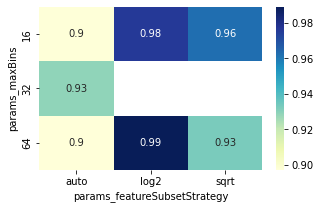




Generating heatmap for columns: params_featureSubsetStrategy, params_numTrees


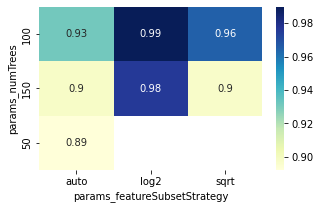




Generating heatmap for columns: params_featureSubsetStrategy, params_subsamplingRate


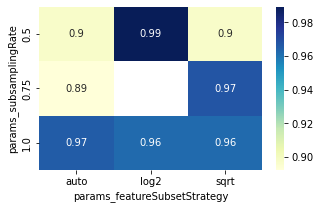




Generating heatmap for columns: params_featureSubsetStrategy, params_minInstancesPerNode


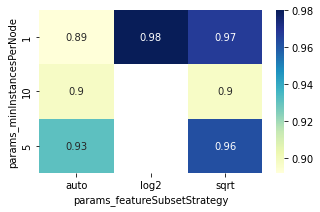




Generating heatmap for columns: params_featureSubsetStrategy, params_maxDepth


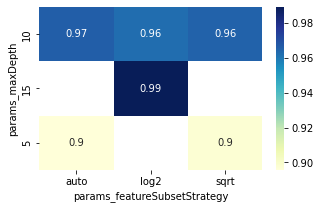




Generating heatmap for columns: params_maxBins, params_numTrees


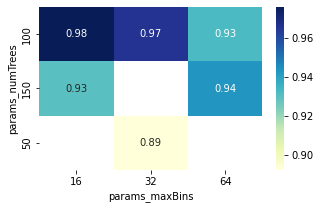




Generating heatmap for columns: params_maxBins, params_subsamplingRate


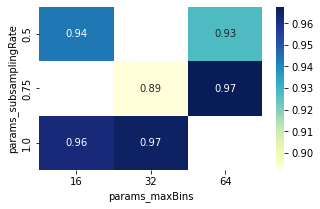




Generating heatmap for columns: params_maxBins, params_minInstancesPerNode


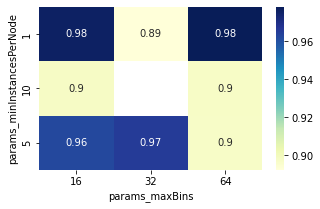




Generating heatmap for columns: params_maxBins, params_maxDepth


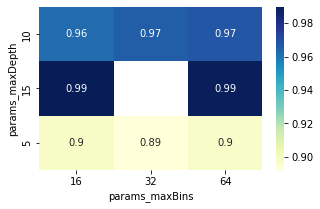




Generating heatmap for columns: params_numTrees, params_subsamplingRate


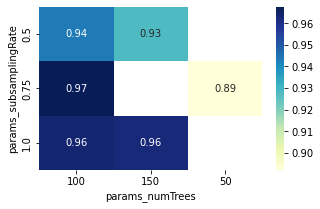




Generating heatmap for columns: params_numTrees, params_minInstancesPerNode


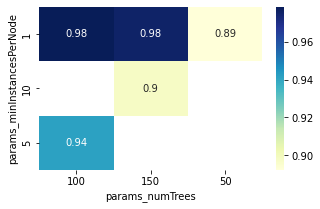




Generating heatmap for columns: params_numTrees, params_maxDepth


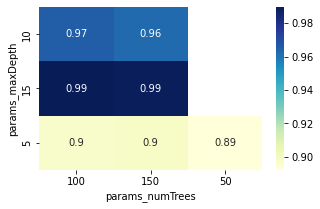




Generating heatmap for columns: params_subsamplingRate, params_minInstancesPerNode


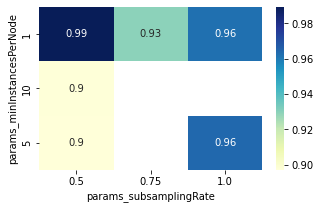




Generating heatmap for columns: params_subsamplingRate, params_maxDepth


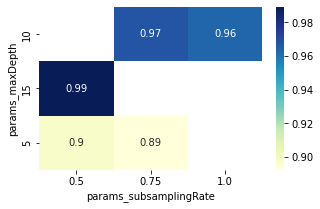




Generating heatmap for columns: params_minInstancesPerNode, params_maxDepth


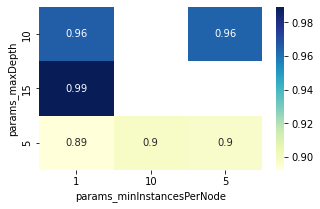

In [ ]:
expId = [3971974859204855]
runs = mlflow.search_runs(experiment_ids=expId)
metrics_df = spark.createDataFrame(runs)
        
columns = ['params_featureSubsetStrategy', 
           'params_maxBins', 
           'params_numTrees', 
           'params_subsamplingRate', 
           'params_minInstancesPerNode', 
           'params_maxDepth']

metric_column = 'metrics_f1'

generate_all_pair_heatmaps(metrics_df, columns, metric_column)

## Evaluation of Parameter Score Combination for Random Forest Classifier

In our analysis, we aim to find the optimal parameter combinations for our Random Forest Classifier model that will provide us with the best F1 score.

### Parameter Combinations and Correlation Analysis

The parameters that we are considering for tuning include:

- `params_featureSubsetStrategy`
- `params_maxBins`
- `params_numTrees`
- `params_subsamplingRate`
- `params_minInstancesPerNode`
- `params_maxDepth`

After analyzing the correlations between these parameters, we also found several interesting trends:

1. `params_featureSubsetStrategy`: The feature subset strategy of `log2` often yields higher F1 scores. Moreover, it seems to be more beneficial when combined with `params_maxBins` of 64, `params_numTrees` of 150 or 100, and `params_maxDepth` of 15.

2. `params_maxBins` and `params_numTrees`: A combination of a lower number of bins (`params_maxBins` set to 16) and a middle-high number of trees (`params_numTrees` set to 100) tends to provide higher F1 scores.

3. `params_subsamplingRate`: A high Subsampling rates of 1.0 often yield the best results. This suggests a possible tendency that these subsampling rates are more effective for this model.


Here, too, it is difficult to make clear statements about parameters, since the final performance depends on too many factors at the same time. Therefore, we have made an in-depth analysis for both models and selected the best f1 score in each case. 

### Best Parameter Combinations

Based on our analysis, we have identified two parameter combinations that show promising results in terms of the F1 score.

**Best Parameter Combination 1:**

- `params_featureSubsetStrategy`: log2
- `params_maxBins`: 64
- `params_numTrees`: 150
- `params_subsamplingRate`: 0.5
- `params_minInstancesPerNode`: 1
- `params_maxDepth`: 15
- Metric f1: 0.989

This combination yields an F1 score of approximately 0.989, suggesting a highly efficient model with excellent balance between precision and recall.

**Best Parameter Combination 2:**

- `params_featureSubsetStrategy`: log2
- `params_maxBins`: 16
- `params_numTrees`: 100
- `params_subsamplingRate`: 0.5
- `params_minInstancesPerNode`: 1
- `params_maxDepth`: 15
- Metric f1: 0.990

This combination, in contrast, leads to an F1 score of roughly 0.990, which is marginally better than the first combination. This signifies a slight improvement in model efficiency.

### Parameter Score Combination: Conclusion

These parameter combinations and the corresponding F1 scores suggest that the model's performance can be significantly influenced by tuning these parameters. It's important to note that the best parameter values can vary depending on the specific data and business requirements (e.g. Data Drift).

**Loading the best parameter value combination for RandomForest**

In [ ]:
experiment_id = "3971974859204855"

# Load metadata of the best run from the experiment
best_run = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["metrics.f1 desc"], max_results=1)

metric_value = best_run.iloc[0]["metrics.f1"]

# Print the value of the metric
print("metric: {}".format(metric_value))

# Load the run ID of the best run
model_uri = "runs:/{}/model".format(best_run.iloc[0].run_id)

# Load parameters of the best run
model_final_rf = mlflow.spark.load_model(model_uri)
parameters = model_final_rf.stages[-1].extractParamMap()

# Print best parameters
for param_name, param_value in parameters.items():
    print("{}: {}".format(param_name.name, param_value))

2023/06/10 18:36:41 INFO mlflow.spark: 'runs:/88fbbe1eeab645fbae59c0acaa7f3683/model' resolved as 'dbfs:/databricks/mlflow-tracking/3971974859204855/88fbbe1eeab645fbae59c0acaa7f3683/artifacts/model'


metric: 0.9897061381072175


2023/06/10 18:36:49 INFO mlflow.spark: URI 'runs:/88fbbe1eeab645fbae59c0acaa7f3683/model/sparkml' does not point to the current DFS.
2023/06/10 18:36:49 INFO mlflow.spark: File 'runs:/88fbbe1eeab645fbae59c0acaa7f3683/model/sparkml' not found on DFS. Will attempt to upload the file.
2023/06/10 18:36:55 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/e401f8fa-8f20-4c39-a5f1-79f2d104d581


bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: log2
featuresCol: scaled_features
impurity: gini
labelCol: label
leafCol: 
maxBins: 16
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -5248438941428709144
subsamplingRate: 0.5
weightCol: weight


#### Step 4: Generate the targetting with your model and analyze the results of `JUNE`

In [ ]:
def test_results_applying_target(test_month: str = '2021-06-01', target: DataFrame=None, orders_sample: DataFrame=None, test_sample:DataFrame=None):

    #orders_sample = spark.read.parquet(f"s3://dev-ifood-kairos/misc/bda/ord_sample")
    #test_sample = spark.read.parquet(f"s3://dev-ifood-kairos/misc/bda/mkt_test_assignment_sample")
    
    orders_by_account = (
      orders_sample
      .filter( f.date_trunc('month', f.col('reference_date'))==test_month)
      .groupBy('account_id', 'reference_date')
      .agg(
          f.countDistinct('order_id').alias('orders'),
          f.sum('discount_vouchers_used').alias('vouchers_used'),
          f.sum('subsidy').alias('subsidy'),
          f.avg('order_total').alias('aov')
      )
    )

    if target:
      test_sample = ( test_sample.join(target, ['account_id'], 'inner') )

    df = (
      test_sample
      .filter(f.col('reference_month')==test_month)
      .join(orders_by_account,  ['account_id', 'reference_date'], 'left')
      .groupBy('test_assignment')
      .agg(
          f.count('account_id').alias('test_size'),
          f.round((f.sum( f.when(f.col('orders') > 0, 1).otherwise(0) )), 3).alias('conversions'),
          f.round((f.sum( f.when(f.col('orders') > 0, 1).otherwise(0) ) / f.count('account_id') ), 3).alias('conversion_rate'),
          f.round(f.sum('subsidy'), 0).alias('sub_total'),
          (f.sum( f.when(f.col('vouchers_used') > 0, 1).otherwise(0) ) ).alias('vouchers_used'),
          f.avg('aov').alias('aov')
      )
    )
    df.display()
    return df

**evaluating baseline target customers**

In [ ]:
target_customers_baseline =( 
  orders_sample
  .filter(f.col('reference_date')>='2021-05-01')
  .filter(f.col('reference_date')<'2021-06-01')
  .groupBy('account_id')
  .agg(
      f.avg('order_total').alias('aov')
  )
  .filter(f.col('aov')<2000)
  .select('account_id')
  .distinct()
)

In [ ]:
test_results_baseline = test_results_applying_target('2021-06-01', target_customers_baseline)
test_results_baseline.write.mode("overwrite").parquet("/FileStore/bdm_data_train/test_results_baseline.parquet")

In [ ]:
df = spark.read.parquet("/FileStore/bdm_data_train/test_results_baseline.parquet")

test_df = df.filter(df.test_assignment == "test")
control_df = df.filter(df.test_assignment == "control")

IRR = test_df.select("conversion_rate").first()[0] - control_df.select("conversion_rate").first()[0]
print('incremental response rate (IRR) = ', IRR)

MUB = IRR * test_df.select("test_size").first()[0]
print('Incremental Conversions (or incremental MUB) = ', MUB)

CANNIB = (test_df.select("vouchers_used").first()[0] - MUB)/test_df.select("vouchers_used").first()[0]
print('Cannibalization = ', CANNIB)

NIR = ((test_df.select("aov").first()[0] * test_df.select("conversion_rate").first()[0]) - (control_df.select("aov").first()[0] * control_df.select("conversion_rate").first()[0])) * test_df.select("test_size").first()[0]
print('NIR(net incremental revenue) = ', NIR)

CIP = test_df.select("sub_total").first()[0] / MUB
print('Cost per Increment = ', CIP)

CIProfit = NIR - test_df.select("sub_total").first()[0]
print('campaign incremental profit  = ', CIProfit)

incremental response rate (IRR) =  0.010000000000000009
Incremental Conversions (or incremental MUB) =  216.9700000000002
Cannibalization =  0.5882922201138516
NIR(net incremental revenue) =  127971.24441714025
Cost per Increment =  913.0571046688474
campaign incremental profit  =  -70134.75558285975


**evaluating the model predicted target customer**

In [ ]:
def target_customers(orders_df: DataFrame, items_df: DataFrame, ab_test: DataFrame, sess_df: DataFrame, start_date: str, end_date: str): 
  
  test=generate_features(
  orders_df, #Order Data
  items_df, #Item Data
  ab_test, #Ab-test data -> only june or july
  sess_df, #session data
  start_date, #start of the analysis timeframe
  end_date, #end of the analysis timeframe
  "test")
  test=test.drop("reference_date")
  print("Test length:",  test.count())
  
  control=generate_features(
  orders_df, #Order Data
  items_df, #Item Data
  ab_test, #Ab-test data -> only june or july
  sess_df, #session data
  start_date, #start of the analysis timeframe
  end_date, #end of the analysis timeframe
  "control")
  control=control.drop("reference_date")
  print("Control length:",  control.count())


  final = test.union(control)
  df_final = final.dropDuplicates(['account_id'])
  print("final1 length:",  df_final.count())
  
  return df_final
  

In [ ]:
 target_customers = target_customers(orders_sample, 
                                    items_sample, 
                                    ab_test_sample, 
                                    sess_sample, 
                                    start_date="2021-01-01", 
                                    end_date="2021-05-31")

target_customers.write.mode("overwrite").parquet("/FileStore/bdm_data_train/target_customers.parquet")

ab_count 164586
orders_df len:  3378384
items_df len:  3378377
sess_df len:  16110338
Filtering Done
Account Aggregation Done 87201
Items Aggregation Done 87201
Final Row Number 164586
Test length: 164586
ab_count 148476
orders_df len:  3378384
items_df len:  3378377
sess_df len:  16110338
Filtering Done
Account Aggregation Done 87201
Items Aggregation Done 87201
Final Row Number 148476
Control length: 148476
final1 length: 136729


In [ ]:
target_customers = spark.read.parquet("/FileStore/bdm_data_train/target_customers.parquet")
target_customers.count()

Out[26]: 136729

**evaluating the LogisticRegression predicted target customer**

In [ ]:
predictions_lr = model_final_lr.transform(target_customers)
#predictions_lr.display()

In [ ]:
predictions_lr = predictions_lr.filter(predictions_lr["prediction"] != 0)

results_lr = test_results_applying_target('2021-06-01', 
                                          predictions_lr['account_id', 
                                                         'prediction'],
                                          orders_sample,
                                          ab_test_sample)


results_lr.write.mode("overwrite").parquet("/FileStore/bdm_data_train/results_lr.parquet")

test_assignment,test_size,conversions,conversion_rate,sub_total,vouchers_used,aov
control,29642,9584,0.323,0.0,0,2395.5074820881864
test,32476,10493,0.323,283701.0,740,2331.5822548365413


In [ ]:
df = spark.read.parquet("/FileStore/bdm_data_train/results_lr.parquet")

test_df = df.filter(df.test_assignment == "test")
control_df = df.filter(df.test_assignment == "control")

IRR = test_df.select("conversion_rate").first()[0] - control_df.select("conversion_rate").first()[0]
print('incremental response rate (IRR) = ', IRR)

MUB = IRR * test_df.select("test_size").first()[0]
print('Incremental Conversions (or incremental MUB) = ', MUB)

CANNIB = (test_df.select("vouchers_used").first()[0] - MUB)/test_df.select("vouchers_used").first()[0]
print('Cannibalization = ', CANNIB)

NIR = ((test_df.select("aov").first()[0] * test_df.select("conversion_rate").first()[0]) - (control_df.select("aov").first()[0] * control_df.select("conversion_rate").first()[0])) * test_df.select("test_size").first()[0]
print('NIR(net incremental revenue) = ', NIR)

#CIP = test_df.select("sub_total").first()[0] / MUB
print('Cost per Increment = ', CIP)

CIProfit = NIR - test_df.select("sub_total").first()[0]
print('campaign incremental profit  = ', CIProfit)

incremental response rate (IRR) =  0.0
Incremental Conversions (or incremental MUB) =  0.0
Cannibalization =  1.0
NIR(net incremental revenue) =  -670559.5247124906
Cost per Increment =  2002.8712760375192
campaign incremental profit  =  -954260.5247124906


**evaluating the RandomForest predicted target customer**

In [ ]:
predictions_rf = model_final_rf.transform(target_customers)

In [ ]:
predictions_rf = predictions_rf.filter(predictions_rf["prediction"] != 0)

results_rf = test_results_applying_target('2021-06-01', 
                                          predictions_rf['account_id', 
                                                         'prediction'],
                                          orders_sample,
                                          ab_test_sample)

results_rf.write.mode("overwrite").parquet("/FileStore/bdm_data_train/results_rf.parquet")

test_assignment,test_size,conversions,conversion_rate,sub_total,vouchers_used,aov
control,1971,865,0.439,0.0,0,1865.001233140654
test,2214,1097,0.495,190498.0,505,1847.8937291096922


In [ ]:
df = spark.read.parquet("/FileStore/bdm_data_train/results_rf.parquet")

test_df = df.filter(df.test_assignment == "test")
control_df = df.filter(df.test_assignment == "control")

IRR = test_df.select("conversion_rate").first()[0] - control_df.select("conversion_rate").first()[0]
print('incremental response rate (IRR) = ', IRR)

MUB = IRR * test_df.select("test_size").first()[0]
print('Incremental Conversions (or incremental MUB) = ', MUB)

CANNIB = (test_df.select("vouchers_used").first()[0] - MUB)/test_df.select("vouchers_used").first()[0]
print('Cannibalization = ', CANNIB)

NIR = ((test_df.select("aov").first()[0] * test_df.select("conversion_rate").first()[0]) - (control_df.select("aov").first()[0] * control_df.select("conversion_rate").first()[0])) * test_df.select("test_size").first()[0]
print('NIR(net incremental revenue) = ', NIR)

CIP = test_df.select("sub_total").first()[0] / MUB
print('Cost per Increment = ', CIP)

CIProfit = NIR - test_df.select("sub_total").first()[0]
print('campaign incremental profit  = ', CIProfit)

incremental response rate (IRR) =  0.055999999999999994
Incremental Conversions (or incremental MUB) =  123.98399999999998
Cannibalization =  0.7544871287128714
NIR(net incremental revenue) =  212481.685997059
Cost per Increment =  1536.472448057814
campaign incremental profit  =  21983.685997058987


> **Analyze the results. What are your conclusions? Remember to compare the results to the baseline targetting.**

Utilizing the one model approach, the features created and the developed machine learning pipeline the results could are the following:

- The Difference in conversion rates between control and test groups is around 5.6% (IRR), surpassing the baseline model (1%)
- The additional conversion which can be attributed to the test group got surpassed by the baseline model (216 vs 123). This is due to the reason, that the overall number of accounts chosen by the model is significantly smaller.
- The cannibalisation rate was higher for our model (0.75) in comparison to the baseline (0.58).
- The net incremental revenue (the revenue made by sending out the promotion) surpassed the baseline model by 84.610 MU$
- However, the cost per increment is higher than in baseline model (1536 MU$ vs 913 MU$)
- Nevertheless, the proposed uplift modelling approach would have led to a campaign internal profit of 21983 MU$. 92.117 MU$ higher than the baseline approach and positive.
> In conclusion, the proposed methodology outperforms the baseline model on almost all categories for the June A/B testing. However, this is no guarantee that there will be similar results for the A/B July testing. As the June labels were used for training the model, it is likely that it performs better for the June- than for the July-data.
...

#### Step 4: Generate the targetting with your model and analyze the results of `JULY`. 
*(the data of july will be made available 24 hours before the submission deadline)*

In [ ]:
orders_sample_test = spark.read.parquet(f"/FileStore/bda_data_test/ord_sample")
ab_test_sample_test = spark.read.parquet(f"/FileStore/bda_data_test/test/mkt_test_assignment_sample")


**evaluating baseline target customers**

In [ ]:
target_customers_baseline_july =( 
  orders_sample
  .filter(f.col('reference_date')>='2021-06-01')
  .filter(f.col('reference_date')<'2021-07-01')
  .groupBy('account_id')
  .agg(
      f.avg('order_total').alias('aov')
  )
  .filter(f.col('aov')<2000)
  .select('account_id')
  .distinct()
)

In [ ]:
test_results_baseline_july = test_results_applying_target('2021-07-01', 
                                                          target_customers_baseline_july,
                                                          orders_sample_test,
                                                          ab_test_sample_test)
                                                         

test_results_baseline_july.write.mode("overwrite").parquet("/FileStore/bdm_data_train/test_results_baseline_july.parquet")

test_assignment,test_size,conversions,conversion_rate,sub_total,vouchers_used,aov
control,19408,4865,0.251,0.0,0,1622.5609323398464
test,22724,5858,0.258,240216.0,538,1556.1798413138742


In [ ]:
df = spark.read.parquet("/FileStore/bdm_data_train/test_results_baseline_july.parquet")

test_df = df.filter(df.test_assignment == "test")
control_df = df.filter(df.test_assignment == "control")

IRR = test_df.select("conversion_rate").first()[0] - control_df.select("conversion_rate").first()[0]
print('incremental response rate (IRR) = ', IRR)

MUB = IRR * test_df.select("test_size").first()[0]
print('Incremental Conversions (or incremental MUB) = ', MUB)

CANNIB = (test_df.select("vouchers_used").first()[0] - MUB)/test_df.select("vouchers_used").first()[0]
print('Cannibalization = ', CANNIB)

NIR = ((test_df.select("aov").first()[0] * test_df.select("conversion_rate").first()[0]) - (control_df.select("aov").first()[0] * control_df.select("conversion_rate").first()[0])) * test_df.select("test_size").first()[0]
print('NIR(net incremental revenue) = ', NIR)

CIP = test_df.select("sub_total").first()[0] / MUB
print('Cost per Increment = ', CIP)

CIProfit = NIR - test_df.select("sub_total").first()[0]
print('campaign incremental profit  = ', CIProfit)

incremental response rate (IRR) =  0.007000000000000006
Incremental Conversions (or incremental MUB) =  159.06800000000015
Cannibalization =  0.7043345724907061
NIR(net incremental revenue) =  -131081.00703290667
Cost per Increment =  1510.146603968113
campaign incremental profit  =  -371297.00703290664


In [ ]:
target_customers = target_customers(orders_df = orders_sample, 
                                   items_df = items_sample, 
                                   ab_test = ab_test_sample_test, 
                                   sess_df = sess_sample, 
                                   start_date="2021-02-01", 
                                   end_date="2021-06-30")

target_customers.write.mode("overwrite").parquet("/FileStore/bda_data_test/target_customers.parquet")

ab_count 172794
orders_df len:  3443571
items_df len:  3443560
sess_df len:  16411242
Filtering Done
Account Aggregation Done 87215
Items Aggregation Done 87215
Final Row Number 172794
Test length: 172794
ab_count 146851
orders_df len:  3443571
items_df len:  3443560
sess_df len:  16411242
Filtering Done
Account Aggregation Done 87215
Items Aggregation Done 87215
Final Row Number 146851
Control length: 146851
final1 length: 141402


**evaluating the LogisticRegressionpredicted target customer**

In [ ]:
target_customers = spark.read.parquet("/FileStore/bda_data_test/target_customers.parquet")

predictions_lr = model_final_lr.transform(target_customers)

In [ ]:
predictions_lr = predictions_lr.filter(predictions_lr["prediction"] != 0)

results_lr = test_results_applying_target('2021-07-01', 
                                          predictions_lr['account_id', 'prediction'],
                                         orders_sample_test,
                                         ab_test_sample_test)

results_lr.write.mode("overwrite").parquet("/FileStore/bda_data_test/results_lr.parquet")

test_assignment,test_size,conversions,conversion_rate,sub_total,vouchers_used,aov
control,29146,9233,0.317,0.0,0,2386.6403617458955
test,34176,10928,0.32,353724.0,784,2345.649041300619


In [ ]:
df = spark.read.parquet("/FileStore/bda_data_test/results_lr.parquet")

test_df = df.filter(df.test_assignment == "test")
control_df = df.filter(df.test_assignment == "control")

IRR = test_df.select("conversion_rate").first()[0] - control_df.select("conversion_rate").first()[0]
print('incremental response rate (IRR) = ', IRR)

MUB = IRR * test_df.select("test_size").first()[0]
print('Incremental Conversions (or incremental MUB) = ', MUB)

CANNIB = (test_df.select("vouchers_used").first()[0] - MUB)/test_df.select("vouchers_used").first()[0]
print('Cannibalization = ', CANNIB)

NIR = ((test_df.select("aov").first()[0] * test_df.select("conversion_rate").first()[0]) - (control_df.select("aov").first()[0] * control_df.select("conversion_rate").first()[0])) * test_df.select("test_size").first()[0]
print('NIR(net incremental revenue) = ', NIR)

CIP = test_df.select("sub_total").first()[0] / MUB
print('Cost per Increment = ', CIP)

CIProfit = NIR - test_df.select("sub_total").first()[0]
print('campaign incremental profit  = ', CIProfit)

incremental response rate (IRR) =  0.0030000000000000027
Incremental Conversions (or incremental MUB) =  102.52800000000009
Cannibalization =  0.8692244897959182
NIR(net incremental revenue) =  -203596.73460302156
Cost per Increment =  3450.0234082396973
campaign incremental profit  =  -557320.7346030215


**evaluating the RandomForest predicted target customer**

In [ ]:
target_customers = spark.read.parquet("/FileStore/bda_data_test/target_customers.parquet")

predictions_rf = model_final_rf.transform(target_customers)

In [ ]:
predictions_rf = predictions_rf.filter(predictions_rf["prediction"] != 0)

results_rf = test_results_applying_target('2021-07-01', 
                                          predictions_rf['account_id', 'prediction'],
                                         orders_sample_test,
                                         ab_test_sample_test)

results_rf.write.mode("overwrite").parquet("/FileStore/bda_data_test/results_rf.parquet")

test_assignment,test_size,conversions,conversion_rate,sub_total,vouchers_used,aov
control,2200,940,0.427,0.0,0,1905.3011932624104
test,2708,1170,0.432,182087.0,395,1802.2671798433041


In [ ]:
df = spark.read.parquet("/FileStore/bda_data_test/results_rf.parquet")

test_df = df.filter(df.test_assignment == "test")
control_df = df.filter(df.test_assignment == "control")

IRR = test_df.select("conversion_rate").first()[0] - control_df.select("conversion_rate").first()[0]
print('incremental response rate (IRR) = ', IRR)

MUB = IRR * test_df.select("test_size").first()[0]
print('Incremental Conversions (or incremental MUB) = ', MUB)

CANNIB = (test_df.select("vouchers_used").first()[0] - MUB)/test_df.select("vouchers_used").first()[0]
print('Cannibalization = ', CANNIB)

NIR = ((test_df.select("aov").first()[0] * test_df.select("conversion_rate").first()[0]) - (control_df.select("aov").first()[0] * control_df.select("conversion_rate").first()[0])) * test_df.select("test_size").first()[0]
print('NIR(net incremental revenue) = ', NIR)

CIP = test_df.select("sub_total").first()[0] / MUB
print('Cost per Increment = ', CIP)

CIProfit = NIR - test_df.select("sub_total").first()[0]
print('campaign incremental profit  = ', CIProfit)

incremental response rate (IRR) =  0.0050000000000000044
Incremental Conversions (or incremental MUB) =  13.540000000000012
Cannibalization =  0.9657215189873417
NIR(net incremental revenue) =  -94737.18064564849
Cost per Increment =  13448.079763663209
campaign incremental profit  =  -276824.1806456485


Using the tuned random forest model and the variables calculated using data from February to the end of June a target group for the voucher was created. The results (compared to the baseline approach) are as follows: 

- The Difference in conversion rates between control and test groups is around 0.05% (IRR), underperforming against the baseline model (0.7%)
- The additional conversion which can be attributed to the test group was higher in the baseline model (ML: 14 vs Baseline: 159)
- The cannibalization rate was higher in the machine learning approach with 97% than in the baseline approach (70%). This means that 97% of the customers in the target group would have ordered anyway.
- The net incremental revenue (the revenue made by sending out the promotion) is negative in both models, but the uplift modelling approach produced a better result (-94.737MU$ vs -131.081MU$)
- The cost per increment is significantly higher with the machine learning model than using the baseline model (13.448 MU$ vs 1.510 MU$)
- The proposed uplift modelling approach would have led to a campaign internal profit of –276.824 MU$. The Baseline also fails to make a profit and produces a higher loss on top: -371.297 MU$

> In conclusion the developed model did manage to outperform the baseline model in termso of the campaign internal profit but failed to make a positive profit. We identified several reasons for this result:

- Insufficient variables; There were not enough variables to make reliable predictions
- Too many variables or noisy data: there could be too many variables leading to the curse of dimensionality
- Wrong Classifiers: The models were not sufficient for this problem
- Insufficient Hyperparameter Tuning: not enough hyperparameters were tested
- Too simple approach: The one model approach could be insufficient for this task
- Not enough/imbalanced data: there were not many instances of target customers who reacted to the voucher
- Concept drift: there could be seasonal change in the data which could worsen the performance of the model
- Overfitting: there is also the possibility that the model is overfitted on the June data

The next steps to increase the performance of the data would be to create, select and test more variables, test more classifiers with more hyperparameters, make more experiments to collect more data, and experiment with the timeframes of the data for the variables to detect short or long term trends.

...

In [ ]:
import os

experiment_id = "3971974859204854"
runs = mlflow.search_runs(experiment_ids=[experiment_id])

for i, run in runs.iterrows() :
  run_id = run['run_id']
  local_dir = "/databricks/driver/hypertuning_artifacts_lr"
  artifacts_path = os.path.join(local_dir, run_id)
  os.makedirs(artifacts_path, exist_ok = True) # Create parent directory if it doesn't exist
  mlflow_client = mlflow.tracking.MlflowClient()
  mlflow_client.download_artifacts(run_id,'', artifacts_path)
  
  

<command-3467772525463226>:12: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  mlflow_client.download_artifacts(run_id,'', artifacts_path)


In [ ]:
import shutil

#dbutils.fs.cp('/FileStore/folder_to_zip/', 'file:/databricks/driver/folder_to_zip/', True)
shutil.make_archive('artefacts_lr', 'zip', 'hypertuning_artifacts_lr')
dbutils.fs.cp('file:/databricks/driver/artefacts_lr.zip', '/FileStore/artefacts_lr.zip')

Out[83]: True

In [ ]:
#https://community.cloud.databricks.com/files/artefacts_lr.zip?o=6010521954952532